<a href="https://colab.research.google.com/github/ishwarraja/SOAI-ERAV2/blob/main/S7/ERA1S7F8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [7]:
! nvidia-smi

Fri Jun 16 15:09:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |    599MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [10]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


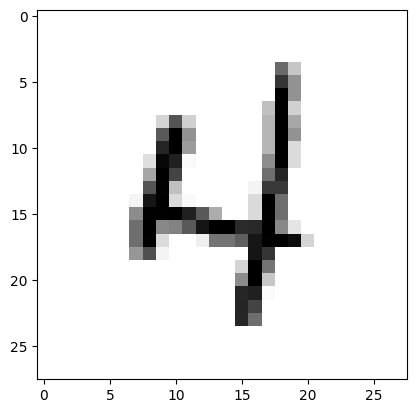

In [12]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

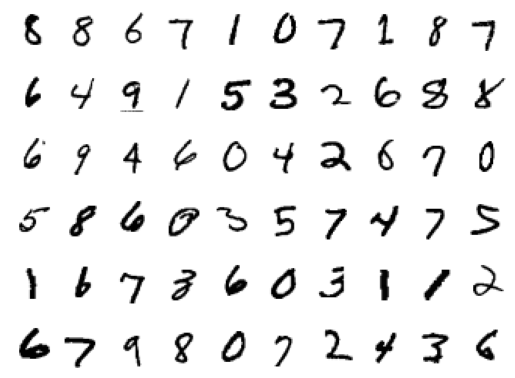

In [13]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [14]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [17]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.05810704454779625 Batch_id=468 Accuracy=88.00: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]



Test set: Average loss: 0.0613, Accuracy: 9828/10000 (98.28%)

EPOCH: 1


Loss=0.04506831243634224 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]



Test set: Average loss: 0.0461, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.031201714649796486 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]



Test set: Average loss: 0.0415, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.04506267234683037 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:19<00:00, 24.61it/s]



Test set: Average loss: 0.0299, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.030790111050009727 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:17<00:00, 26.39it/s]



Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.023980356752872467 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:19<00:00, 23.94it/s]



Test set: Average loss: 0.0256, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.008588677272200584 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]



Test set: Average loss: 0.0263, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.022588886320590973 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:19<00:00, 24.32it/s]



Test set: Average loss: 0.0253, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.017326662316918373 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]



Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.17723627388477325 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:19<00:00, 24.48it/s]



Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.007250689435750246 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 24.12it/s]



Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.005220238119363785 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]



Test set: Average loss: 0.0212, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.022720685228705406 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.37it/s]



Test set: Average loss: 0.0227, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.016558339819312096 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]



Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.027888236567378044 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]



Test set: Average loss: 0.0172, Accuracy: 9954/10000 (99.54%)

EPOCH: 15


Loss=0.008876991458237171 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]



Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


Loss=0.062968410551548 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]



Test set: Average loss: 0.0191, Accuracy: 9948/10000 (99.48%)

EPOCH: 17


Loss=0.0354452021420002 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:19<00:00, 24.25it/s]



Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Loss=0.0028750626370310783 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]



Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.007835295982658863 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]



Test set: Average loss: 0.0176, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

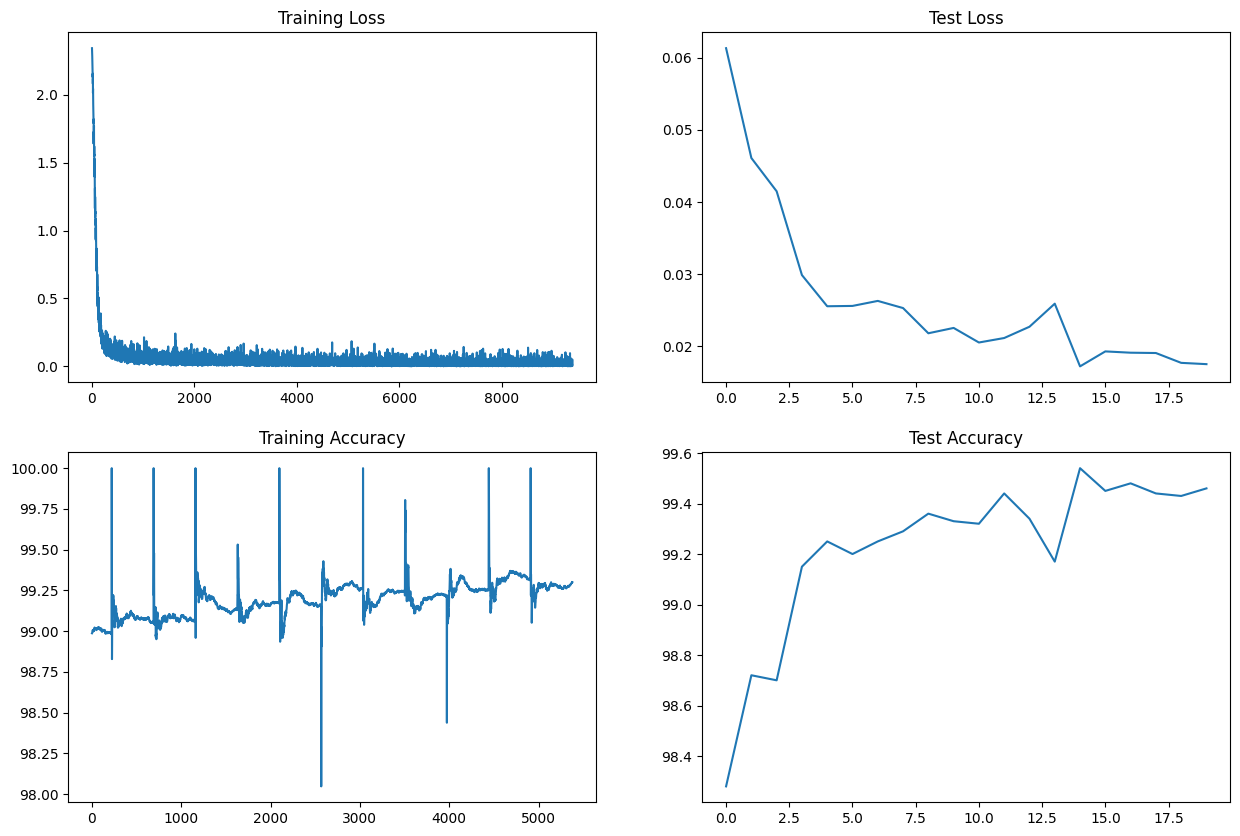

In [29]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(torch.tensor(train_losses))
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")